In [24]:
"""
使用神经网络来做回归问题
"""
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
from IPython.display import Image

In [12]:
"""
构造一个简单的线性数据集以供测试，完全是从scratch实现
"""
# feature个数
num_inputs = 2
num_examples = 1000
true_w = [1, 1]
true_b = 1
# 生成的随机的num_examples的num_inputs
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)
print(features[0], labels[0])

tensor([-0.8757,  0.5073]) tensor(0.6274)


In [13]:
"""
每次拿出一部分数据集
"""
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield features.index_select(0, j), labels.index_select(0, j)       

"""
定义一个可求导的tensor
"""
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)
# 要更新w，b，所以要设置requires_grad_
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)
print(w)
print(b)

"""
批量计算多个wx+b
"""
def linreg(X, w, b):  
    return torch.mm(X, w) + b

"""
平方损失函数
"""
def squared_loss(y_hat, y): 
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

"""
SGD更新w,b。
"""
def sgd(params, lr, batch_size):
    for param in params:
        # 注意这里更改param时用的param.data，求的是一个平均loss
        param.data -= lr * param.grad / batch_size 
        
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
batch_size = 32
for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))
print(true_w, '\n', w)
print(true_b, '\n', b)


tensor([[ 0.0067],
        [-0.0021]], requires_grad=True)
tensor([0.], requires_grad=True)
epoch 1, loss 0.222106
epoch 2, loss 0.033050
epoch 3, loss 0.004948
[1, 1] 
 tensor([[0.9465],
        [0.9417]], requires_grad=True)
1 
 tensor([0.9407], requires_grad=True)


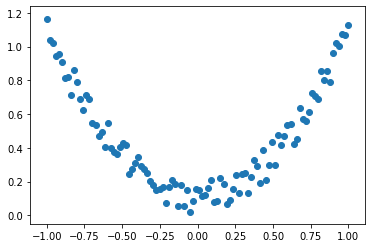

In [14]:
"""
另一组数据加入一些噪音，为后面的做好准备
"""
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 0.2*torch.rand(x.size())     # noisy y data (tensor), shape=(100, 1)
# print(x[0:10], y[0:10])
plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)


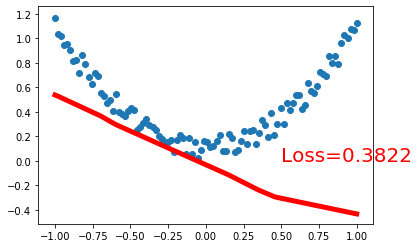

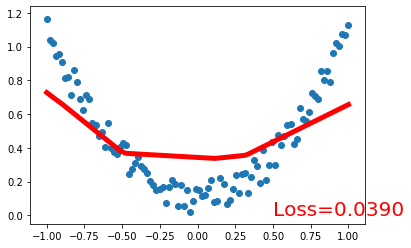

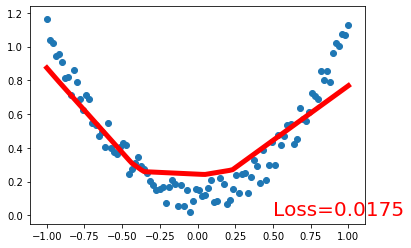

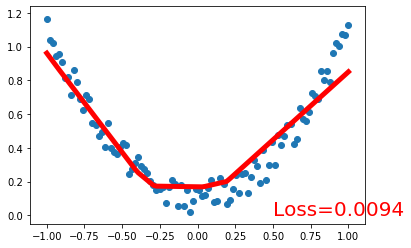

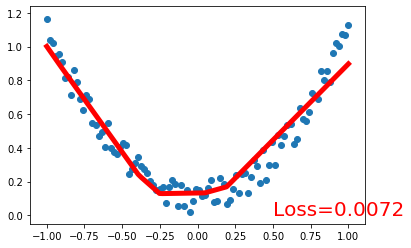

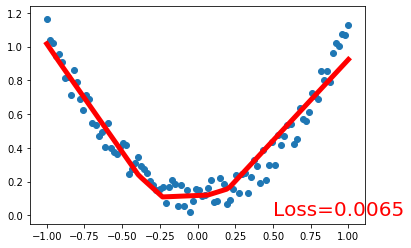

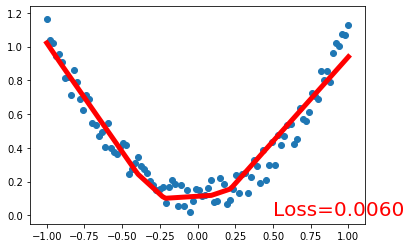

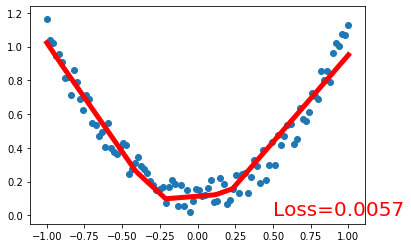

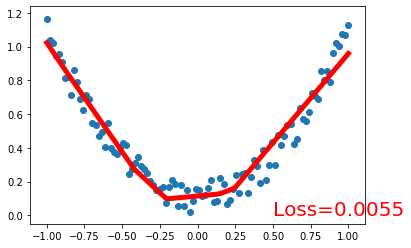

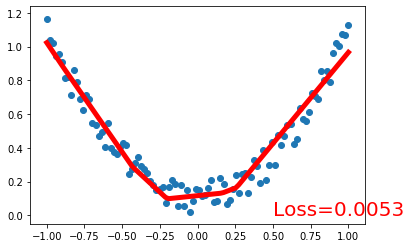

In [15]:
"""
每个网络定义都要实现两个函数
    init - 用来定义本Module要用到的东西
    forward - 定义具体的计算逻辑
"""
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        """借用了torch.nn.Linear，它实际上是使用了线性变换y=xA(T)+b。
        里面还有两个Variable, weight, bias。
        正如前面所说，要想更新权重，需要使用Variable
        """
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        """这里的计算逻辑是：
        dimision 1 -> dimision 10 使用的是第一个torch.nn.Linear
        relu 10 -> 10，激活函数
        dimision 10 -> 1 使用的是第二个torch.nn.Linear
        """
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

net = Net(n_feature=1, n_hidden=10, n_output=1)     # define the network
print(net)  # net architecture
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
plt.ion()   # something about plotting
for t in range(200):
    """
    这里的训练都是一个模板：
    1. 先获取预测的标量或者向量结果。
    2. 算loss。
    3. optimizer.zero_grad()
    4. loss.backward()
    5. optimizer.step() 
    backward()导致所有的grad=True的挂上梯度，step更新梯度，zero_grad()把上次挂上的梯度
    清零。
    """
    prediction = net(x)     # input x and predict based on x
    loss = loss_func(prediction, y) # must be (1. nn output, 2. target)
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    if t % 20 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)
plt.ioff()
plt.show()

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)


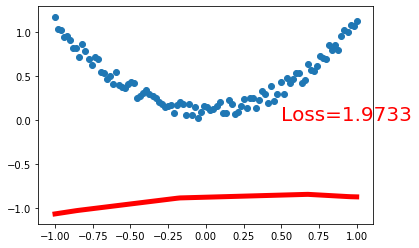

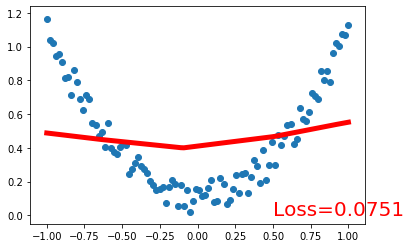

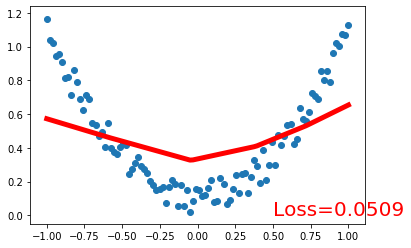

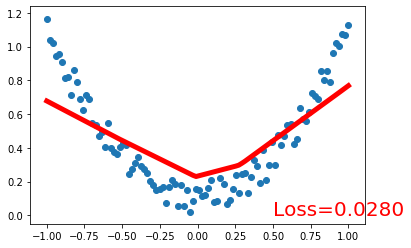

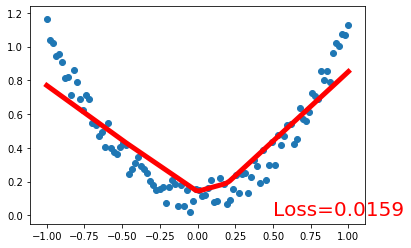

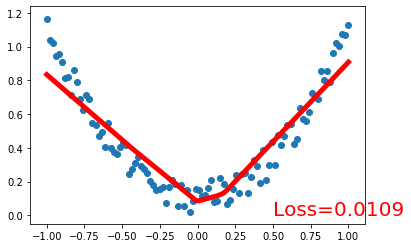

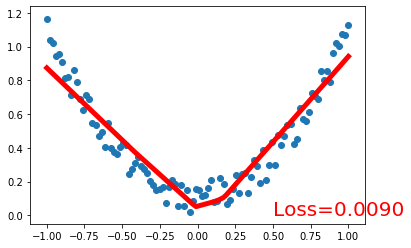

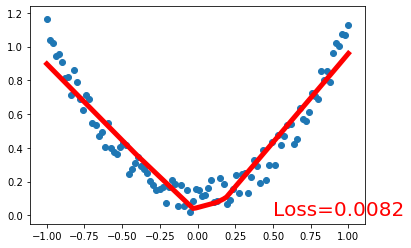

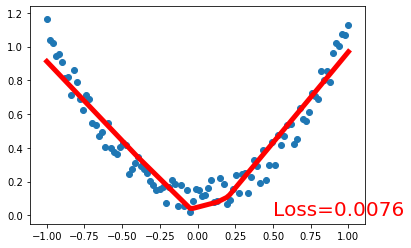

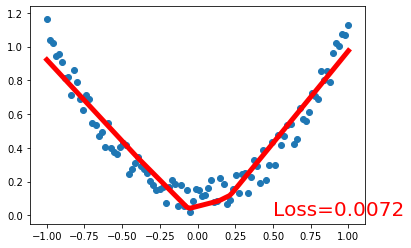

In [17]:
"""
更简洁的Sequential方式搭建一个类似的网络
"""
net2 = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1)
)
print(net2)
optimizer2 = torch.optim.SGD(net2.parameters(), lr=0.2)
loss_func2 = torch.nn.MSELoss()  # this is for regression mean squared loss
plt.ion()   # something about plotting
for t in range(200):
    prediction2 = net2(x)     # input x and predict based on x
    loss2 = loss_func2(prediction2, y)     # must be (1. nn output, 2. target)
    optimizer2.zero_grad()   # clear gradients for next train
    loss2.backward()         # backpropagation, compute gradients
    optimizer2.step()        # apply gradients
    if t % 20 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction2.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss2.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)

plt.ioff()
plt.show()

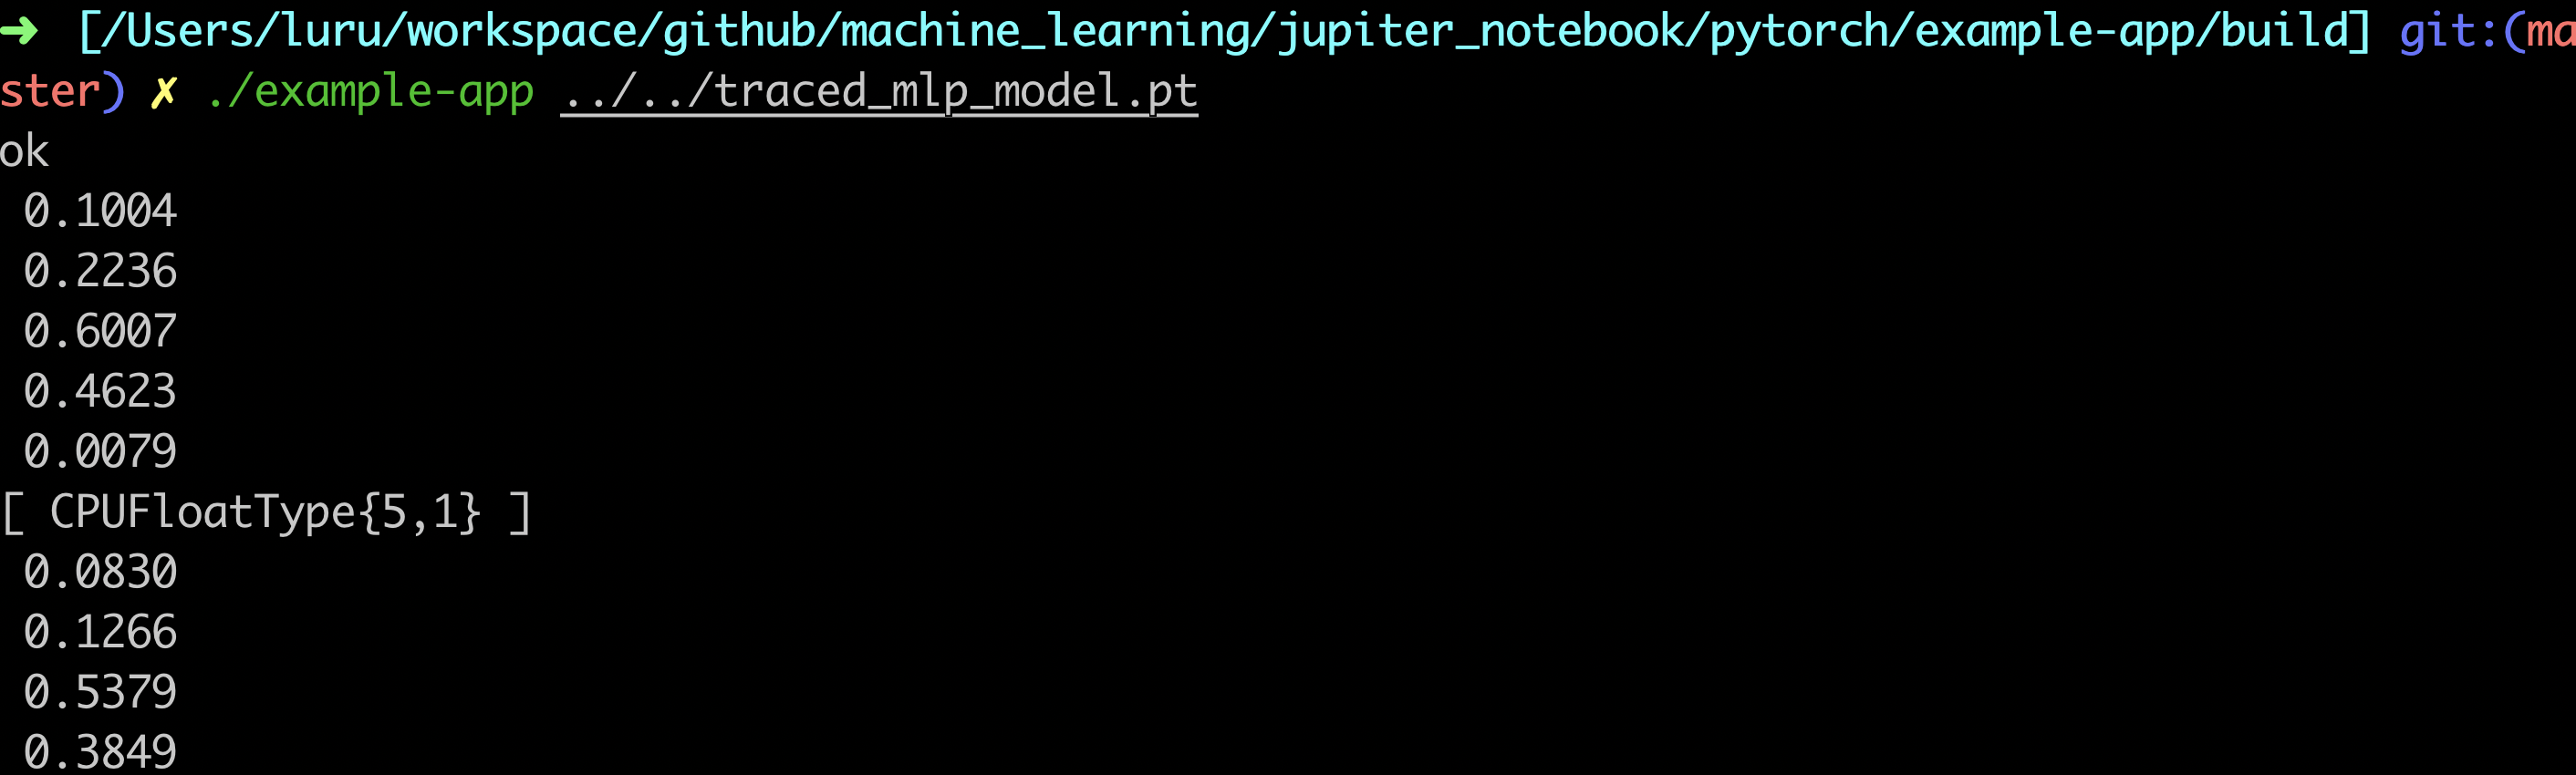

In [25]:
Image(filename='images/pytorch_cpp_serving_output.png', width=500)

In [28]:
# 测试libpytorch的serving
sm = torch.jit.script(net2)
sm.save("traced_mlp_model.pt")

cpp_inputs = torch.FloatTensor([[0.1004],[0.2236], [0.6007], [0.4623]])  
print(net2(cpp_inputs))

tensor([[0.0830],
        [0.1266],
        [0.5379],
        [0.3849]], grad_fn=<AddmmBackward>)
